## Variational autoencoders

http://tiao.io/posts/implementing-variational-autoencoders-in-keras-beyond-the-quickstart-tutorial/
http://tiao.io/listings/vae/variational_autoencoder.ipynb.html

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import backend as K

from keras.layers import (Input, InputLayer, Dense, Lambda, Layer, 
                          Add, Multiply)
from keras.models import Model, Sequential
from keras.datasets import mnist

import pandas as pd

from matplotlib.ticker import FormatStrFormatter
from keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
np.set_printoptions(precision=2,
                    edgeitems=3,
                    linewidth=80,
                    suppress=True)
'TensorFlow version: ' + K.tf.__version__

'TensorFlow version: 1.6.0'

### Dataset

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.expand_dims(x_train, axis=-1) / 255.
x_test = np.expand_dims(x_test, axis=-1) / 255.

img_rows, img_cols, img_chns = x_train.shape[1:]

original_dim = img_rows * img_cols
intermediate_dim = 256
latent_dim = 2
batch_size = 100
epochs = 50
epsilon_std = 1.0

## Model specification

### Encoder

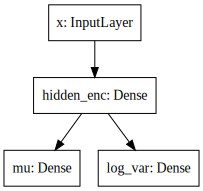

In [4]:
x = Input(shape=(original_dim,), name='x')
h = Dense(intermediate_dim, activation='relu', 
          name='hidden_enc')(x)
z_mu = Dense(latent_dim, name='mu')(h)
z_log_var = Dense(latent_dim, name='log_var')(h)
z_sigma = Lambda(lambda t: K.exp(.5*t), name='sigma')(z_log_var)

m = Model(inputs=x, outputs=[z_mu, z_log_var])

SVG(model_to_dot(m, show_shapes=False).create(prog='dot', format='svg'))

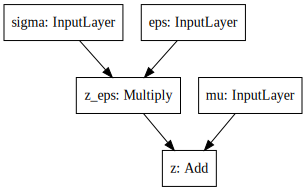

In [5]:
z_mu = Input(shape=(latent_dim,), name='mu')
z_sigma = Input(shape=(latent_dim,), name='sigma')
eps = Input(shape=(latent_dim,), name='eps')
z_eps = Multiply(name='z_eps')([z_sigma, eps])
z = Add(name='z')([z_mu, z_eps])

m = Model(inputs=[eps, z_mu, z_sigma], outputs=z)

SVG(model_to_dot(m, show_shapes=False)
    .create(prog='dot', format='svg'))

### Simplification

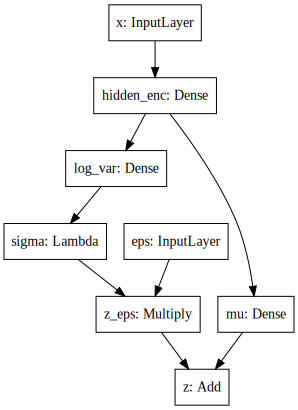

In [6]:
x = Input(shape=(original_dim,), name='x')
h = Dense(intermediate_dim, activation='relu', 
          name='hidden_enc')(x)
z_mu = Dense(latent_dim, name='mu')(h)
z_log_var = Dense(latent_dim, name='log_var')(h)
z_sigma = Lambda(lambda t: K.exp(.5*t), name='sigma')(z_log_var)

eps = Input(shape=(latent_dim,), name='eps')
z_eps = Multiply(name='z_eps')([z_sigma, eps])
z = Add(name='z')([z_mu, z_eps])

encoder = Model(inputs=[x, eps], outputs=z)

SVG(model_to_dot(encoder, show_shapes=False)
    .create(prog='dot', format='svg'))

### Full architecture visualization with auxiliary layers

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


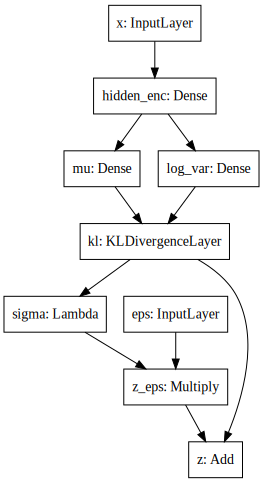

In [7]:
class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

    
x = Input(shape=(original_dim,), name='x')
h = Dense(intermediate_dim, activation='relu', 
          name='hidden_enc')(x)
z_mu = Dense(latent_dim, name='mu')(h)
z_log_var = Dense(latent_dim, name='log_var')(h)
z_mu, z_log_var = KLDivergenceLayer(name='kl')([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t), name='sigma')(z_log_var)

eps = Input(tensor=K.random_normal(shape=(K.shape(x)[0], 
                                          latent_dim)), name='eps')
z_eps = Multiply(name='z_eps')([z_sigma, eps])
z = Add(name='z')([z_mu, z_eps])

encoder = Model(inputs=[x, eps], outputs=z)

SVG(model_to_dot(encoder, show_shapes=False)
    .create(prog='dot', format='svg'))

### Decoder

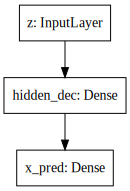

In [8]:
decoder = Sequential([
  Dense(intermediate_dim, input_dim=latent_dim, 
        activation='relu', name='hidden_dec'),
  Dense(original_dim, activation='sigmoid', name='x_pred')
], name='decoder')

# equivalent to above. we specify InputLayer 
# explicitly to set layer name for architecture diagram 
decoder = Sequential([
    InputLayer(input_shape=(latent_dim,), name='z'),
    Dense(intermediate_dim, input_shape=(latent_dim,),
          activation='relu', name='hidden_dec'),
    Dense(original_dim, activation='sigmoid', name='x_pred')
], name='decoder')

SVG(model_to_dot(decoder, show_shapes=False)
    .create(prog='dot', format='svg'))

### The whole VAE

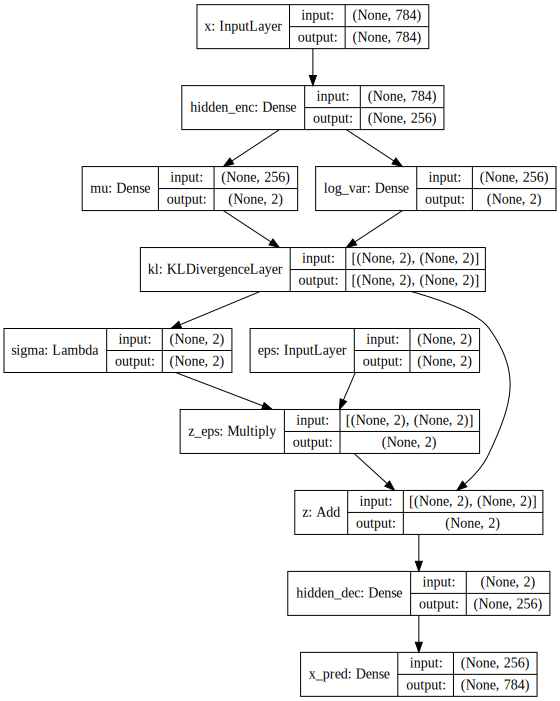

In [9]:
x_pred = decoder(z)

# again, equivalent to above. fleshing it out fully
# for final end-to-end vae architecture visualization;
# otherwise, sequential models just get chunked into
# single layer
h_dec = Dense(intermediate_dim, activation='relu', 
              name='hidden_dec')(z)
x_pred = Dense(original_dim, activation='sigmoid', 
               name='x_pred')(h_dec)

vae = Model(inputs=[x, eps], outputs=x_pred)

SVG(model_to_dot(vae, show_shapes=True)
    .create(prog='dot', format='svg'))

In [10]:
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(shape=(K.shape(x)[0], 
                                          latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

x_pred = decoder(z)

vae = Model(inputs=[x, eps], outputs=x_pred, name='vae')
vae.compile(optimizer='rmsprop', loss=nll)

In [26]:
#SVG(model_to_dot(vae, show_shapes=True)
#    .create(prog='dot', format='svg'))

In [11]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.

hist = vae.fit(
    x_train,
    x_train,
    shuffle=True,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, x_test)
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s - loss: 190.4866 - val_loss: 172.5184
Epoch 2/50
60000/60000 [==============================] - 2s - loss: 170.1450 - val_loss: 167.8373
Epoch 3/50
60000/60000 [==============================] - 2s - loss: 166.6513 - val_loss: 165.8813
Epoch 4/50
60000/60000 [==============================] - 2s - loss: 164.5829 - val_loss: 164.0456
Epoch 5/50
60000/60000 [==============================] - 2s - loss: 163.1373 - val_loss: 162.9493
Epoch 6/50
60000/60000 [==============================] - 2s - loss: 161.8903 - val_loss: 161.6827
Epoch 7/50
60000/60000 [==============================] - 2s - loss: 160.7926 - val_loss: 160.5996
Epoch 8/50
60000/60000 [==============================] - 2s - loss: 159.7752 - val_loss: 159.4021
Epoch 9/50
60000/60000 [==============================] - 2s - loss: 158.7716 - val_loss: 158.8773
Epoch 10/50
60000/60000 [==============================] - 

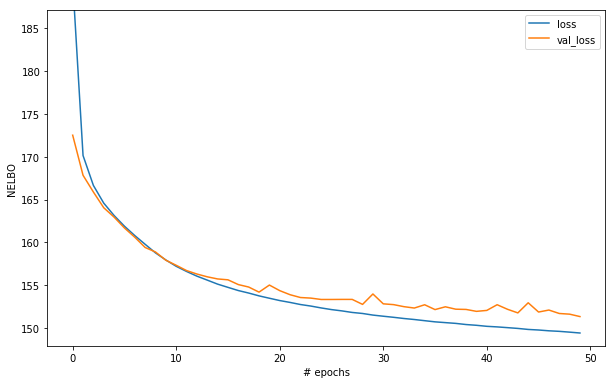

In [14]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

fig, ax = plt.subplots(figsize=golden_size(10))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99*hist_df[1:].values.min(), 
            1.1*hist_df[1:].values.max())

plt.savefig('nelbo.svg', format='svg')
plt.show()


### Observed space manifold

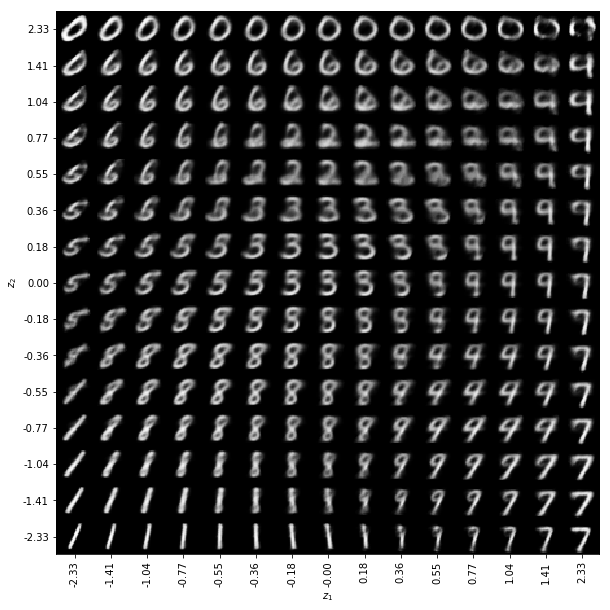

In [18]:
# display a 2D manifold of the images
n = 15  # figure with 15x15 images
quantile_min = 0.01
quantile_max = 0.99

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(quantile_min, quantile_max, n))
z2 = norm.ppf(np.linspace(quantile_max, quantile_min, n))
z_grid = np.dstack(np.meshgrid(z1, z2))

x_pred_grid = decoder.predict(z_grid.reshape(n*n, latent_dim)) \
                     .reshape(n, n, img_rows, img_cols)
    

fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')

ax.set_xticks(np.arange(0, n*img_rows, img_rows) + .5 * img_rows)
ax.set_xticklabels(map('{:.2f}'.format, z1), rotation=90)

ax.set_yticks(np.arange(0, n*img_cols, img_cols) + .5 * img_cols)
ax.set_yticklabels(map('{:.2f}'.format, z2))

ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')

plt.savefig('result_manifold.png')
plt.show()

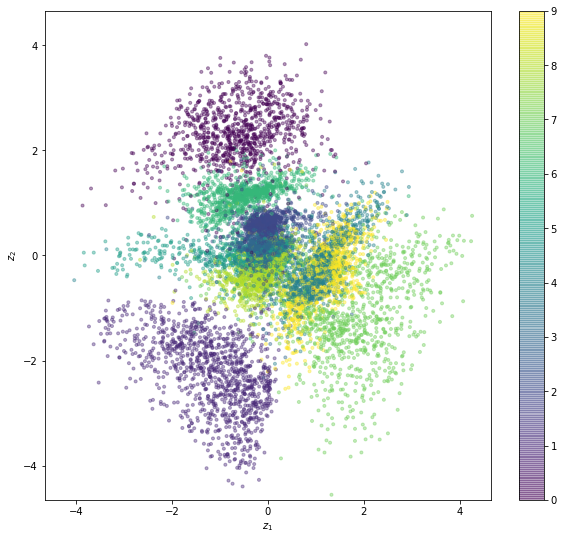

In [21]:
# deterministic test time encoder
test_encoder = Model(x, z_mu)

# display a 2D plot of the digit classes in the latent space
z_test = test_encoder.predict(x_test, batch_size=batch_size)

fig, ax = plt.subplots(figsize=(10, 9))

cbar = ax.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
                   alpha=.4, s=3**2, cmap='viridis')
fig.colorbar(cbar, ax=ax)

ax.set_xlim(2.*norm.ppf((quantile_min, quantile_max)))
ax.set_ylim(2.*norm.ppf((quantile_min, quantile_max)))

ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')

plt.savefig('result_latent_space.png')
plt.show()

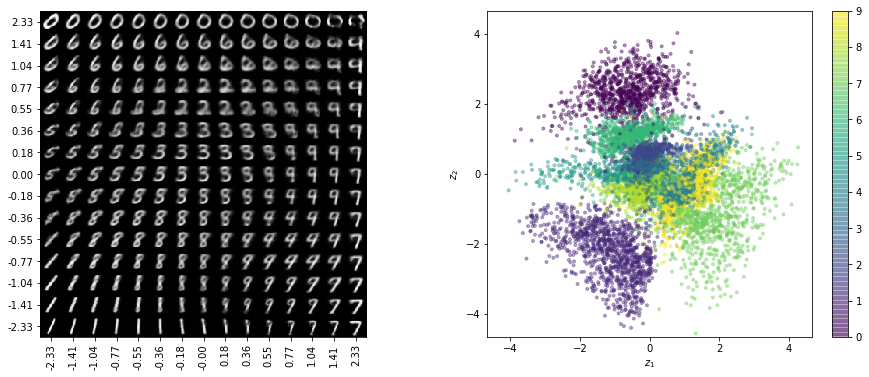

In [24]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))

ax1.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')

ax1.set_xticks(np.arange(0, n*img_rows, img_rows) + .5 * img_rows)
ax1.set_xticklabels(map('{:.2f}'.format, z1), rotation=90)

ax1.set_yticks(np.arange(0, n*img_cols, img_cols) + .5 * img_cols)
ax1.set_yticklabels(map('{:.2f}'.format, z2))

ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')

cbar = ax2.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
                   alpha=.4, s=3**2, cmap='viridis')
fig.colorbar(cbar, ax=ax2)

ax2.set_xlim(2.*norm.ppf((quantile_min, quantile_max)))
ax2.set_ylim(2.*norm.ppf((quantile_min, quantile_max)))

ax2.set_xlabel('$z_1$')
ax2.set_ylabel('$z_2$')

plt.savefig('result_combined.png')
plt.show()